In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

import re

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

get_ipython().magic(u'matplotlib inline')

# import warnings
# warnings.simplefilter(action='ignore', category="DeprecationWarning")

/Users/rose/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_df = pd.read_csv("Data/sales_train.csv")
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
train_df.count()

date              2935849
date_block_num    2935849
shop_id           2935849
item_id           2935849
item_price        2935849
item_cnt_day      2935849
dtype: int64

In [4]:
# categories
category_df = pd.read_csv("data/category_trans.csv")
category_df["item_category_name"] = category_df["item_category_name"].replace(['Книги - Путеводители'], "Books - Literature")
category_df["item_category_name"] = category_df["item_category_name"].replace(['Кино - Blu-Ray 4K'], "Movies - Blu-Ray 4K")

In [5]:
# items
item_df = pd.read_csv("Data/items.csv")
item_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_df = item_df.merge(category_df, how="left")
item_df.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Cinema - DVD
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Programs - Home and Office (Figure)
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Cinema - DVD
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Cinema - DVD
4,***КОРОБКА (СТЕКЛО) D,4,40,Cinema - DVD


In [7]:
# merge the item dataset to train
train_df = train_df.merge(item_df, how="left")
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Movies - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - Vinyl
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Music - CD of branded production


In [8]:
missing_values_count = train_df.isnull().sum()
missing_values_count

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

In [9]:
train_df["category"] = [re.search(r"^[a-zA-Z]+", row).group() for row in train_df["item_category_name"]]
train_df["sub_category"] = [re.search(r"[^ -][^-]*$", row).group() for row in train_df["item_category_name"] if re.search(r"[^ -][^-]*$", row).group() is not None]

In [10]:
#shops
shops_df = pd.read_csv("data/shop_trans.csv")

In [11]:
# merge shops to train dataset
train_df = train_df.merge(shops_df, how="left")

In [12]:
# get the city 
train_df["city"] = [re.search(r"^[a-zA-Z]+", row).group() for row in train_df["shop_name"]]

In [13]:
train_df = train_df.drop(['item_name', 'item_category_name', 'shop_name'],axis=1)

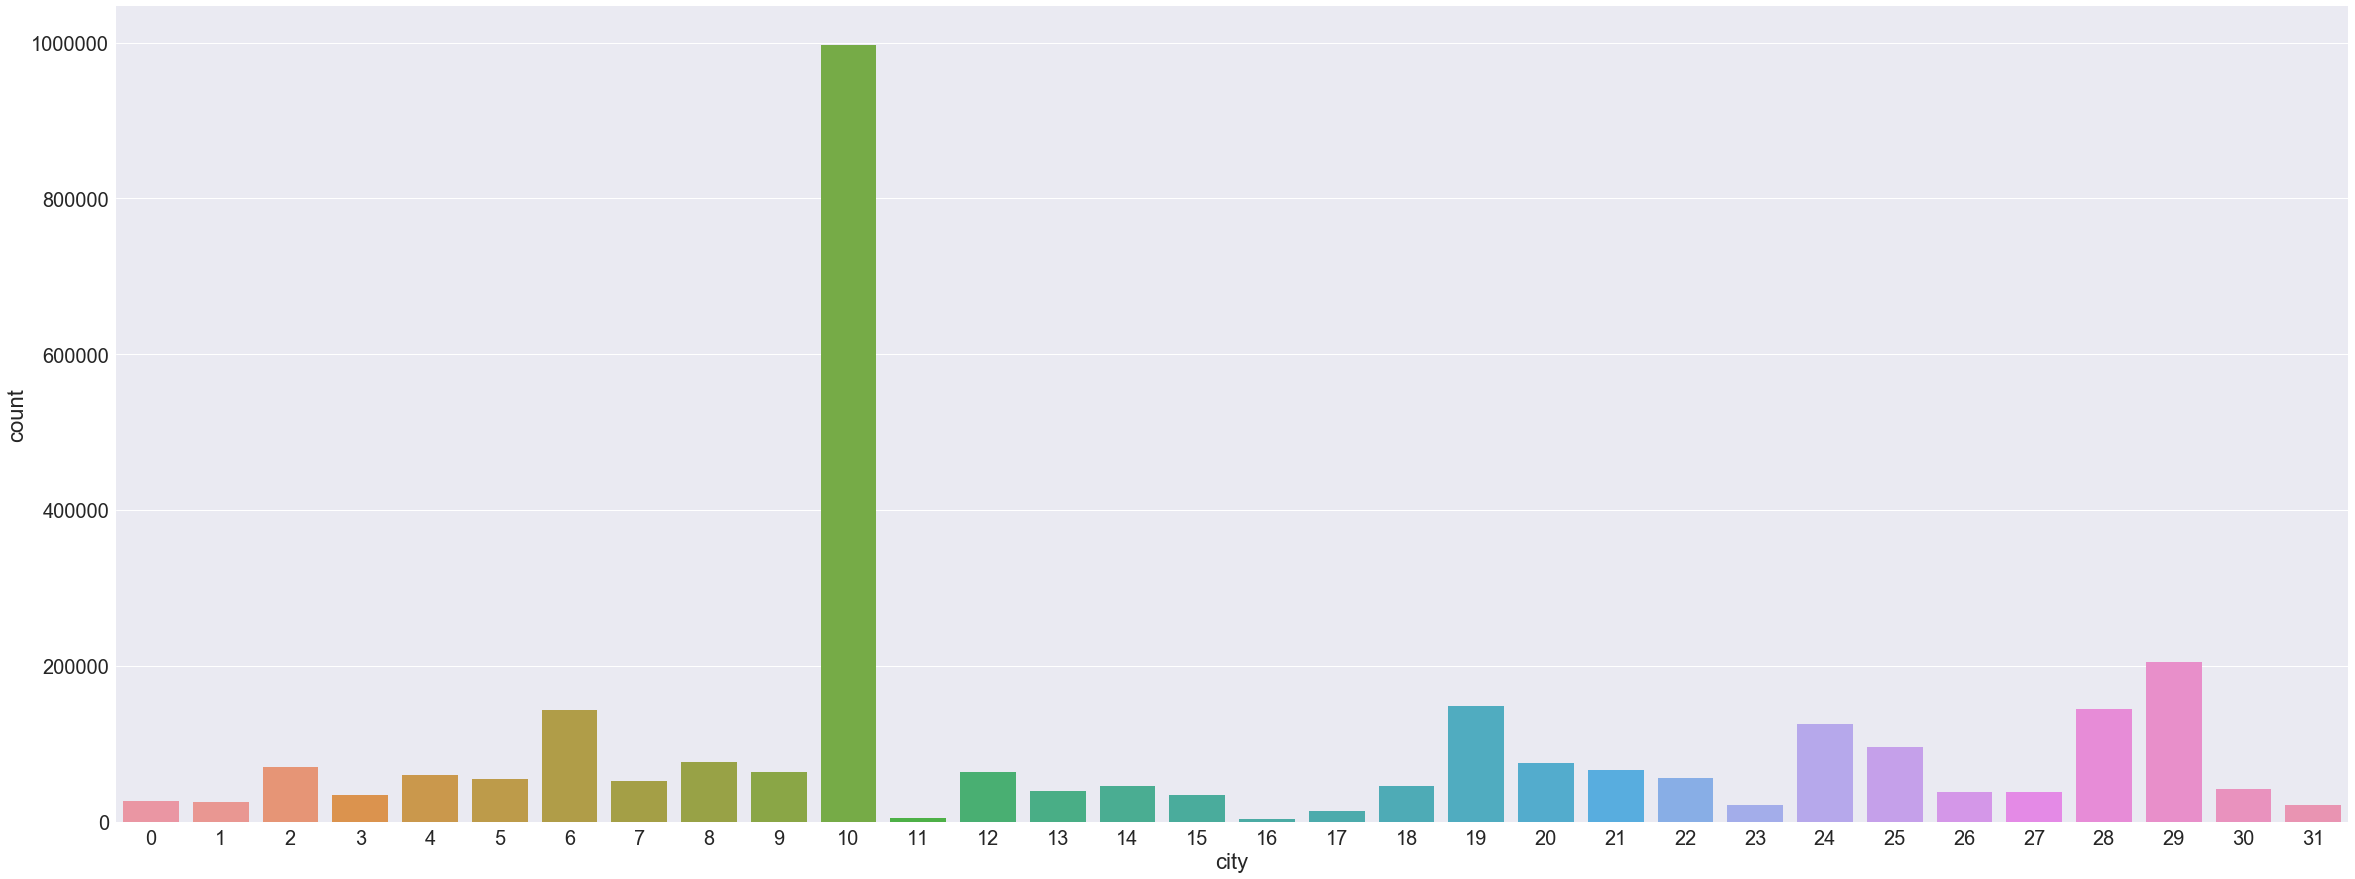

In [14]:
# encoding
le = preprocessing.LabelEncoder()
# city
train_df["city"] = le.fit_transform(train_df["city"])
#category
train_df["category"] = le.fit_transform(train_df["category"])
# sub category
train_df["sub_category"] = le.fit_transform(train_df["sub_category"])

plt.figure(figsize=(40,15))
sns.set(font_scale=2)
sns.countplot(x='city', data=train_df)

In [15]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,category,sub_category,city
0,02.01.2013,0,59,22154,999.00,1.0,37,11,53,30
1,03.01.2013,0,25,2552,899.00,1.0,58,12,64,10
2,05.01.2013,0,25,2552,899.00,-1.0,58,12,64,10
3,06.01.2013,0,25,2554,1709.05,1.0,58,12,64,10
4,15.01.2013,0,25,2555,1099.00,1.0,56,12,12,10


In [16]:
# test data
test_df = pd.read_csv("Data/test.csv")
test_df = test_df.merge(shops_df, how="left")

test_df["city"] = [re.search(r"^[a-zA-Z]+", row).group() for row in test_df["shop_name"]]
test_df["city"] = le.fit_transform(test_df["city"])


In [17]:
def random_date_generator(start_date, range_in_days):
    days_to_add = np.arange(0, range_in_days)
    random_date = np.datetime64(start_date) + np.random.choice(days_to_add)
    return random_date
test_df["date"] = ""
test_df["date"] = [random_date_generator('2015-11-01', 30) for row in test_df["date"]]

In [18]:
# add category id
test_df = test_df.merge(item_df, how="left")
test_df = test_df.drop(['item_name'], axis=1)
test_df['date_block_num']  = 34

###
test_df["category"] = [re.search(r"^[a-zA-Z]+", row).group() for row in test_df["item_category_name"]]
test_df["sub_category"] = [re.search(r"[^ -][^-]*$", row).group() for row in test_df["item_category_name"] if re.search(r"[^ -][^-]*$", row).group() is not None]

In [19]:
# encoding
le = preprocessing.LabelEncoder()
# city
test_df["city"] = le.fit_transform(test_df["city"])
#category
test_df["category"] = le.fit_transform(test_df["category"])
# sub category
test_df["sub_category"] = le.fit_transform(test_df["sub_category"])
test_df = test_df.drop(['item_category_name', 'shop_name'],axis=1)

In [20]:
test_df.head()

,ID,shop_id,item_id,city,date,item_category_id,date_block_num,category,sub_category
0,0,5,5037,23,2015-11-23,19,34,7,34
1,1,5,5320,23,2015-11-29,55,34,11,12
2,2,5,5233,23,2015-11-23,19,34,7,34
3,3,5,5232,23,2015-11-23,23,34,7,49
4,4,5,5268,23,2015-11-03,20,34,7,35


In [21]:
# sum of month 
gp = train_df.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index().rename(index=str, columns={'item_cnt_day': 'item_count_per_month'})
train_df = train_df.merge(gp, on=['date_block_num', 'shop_id', 'item_id'], how='left')

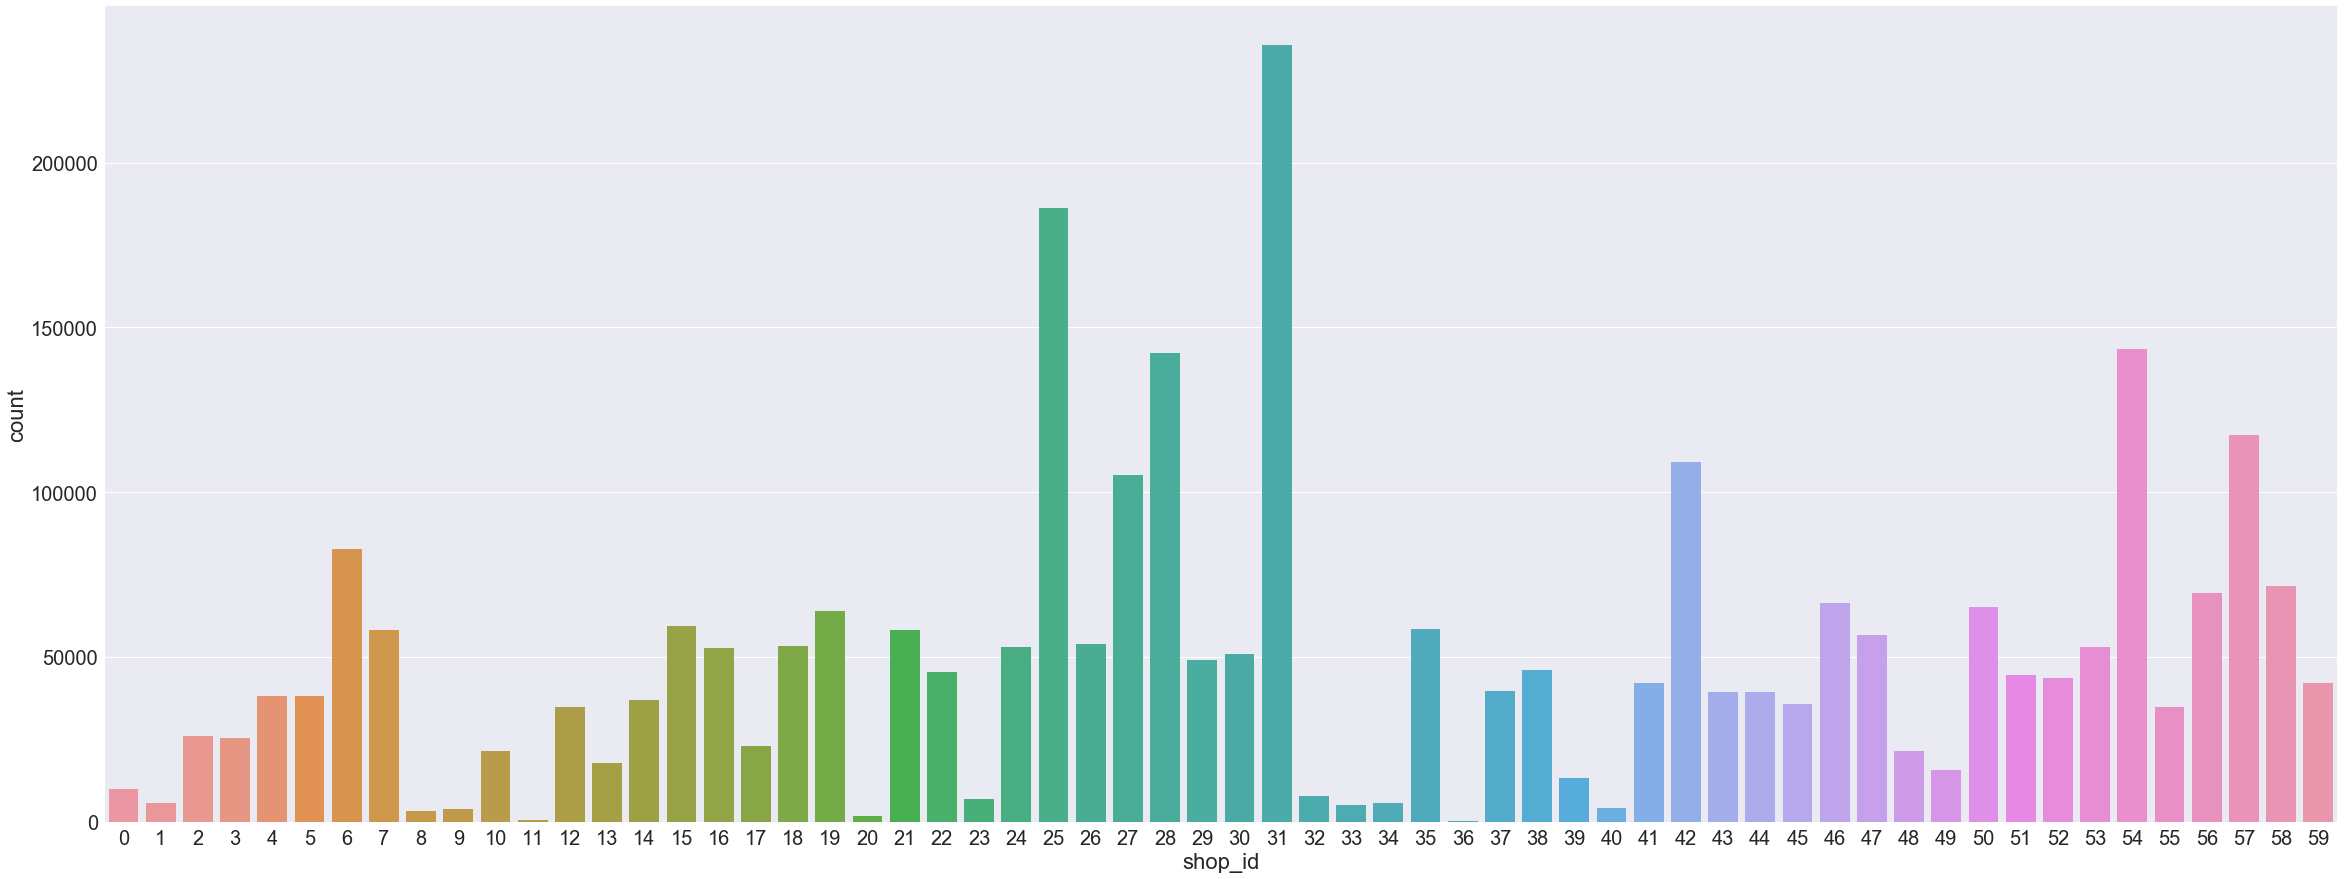

In [22]:
# Analyse the training dataset
# which shop had the highest sales.
plt.figure(figsize=(40,15))
sns.set(font_scale=2)
sns.countplot(x='shop_id', data=train_df)


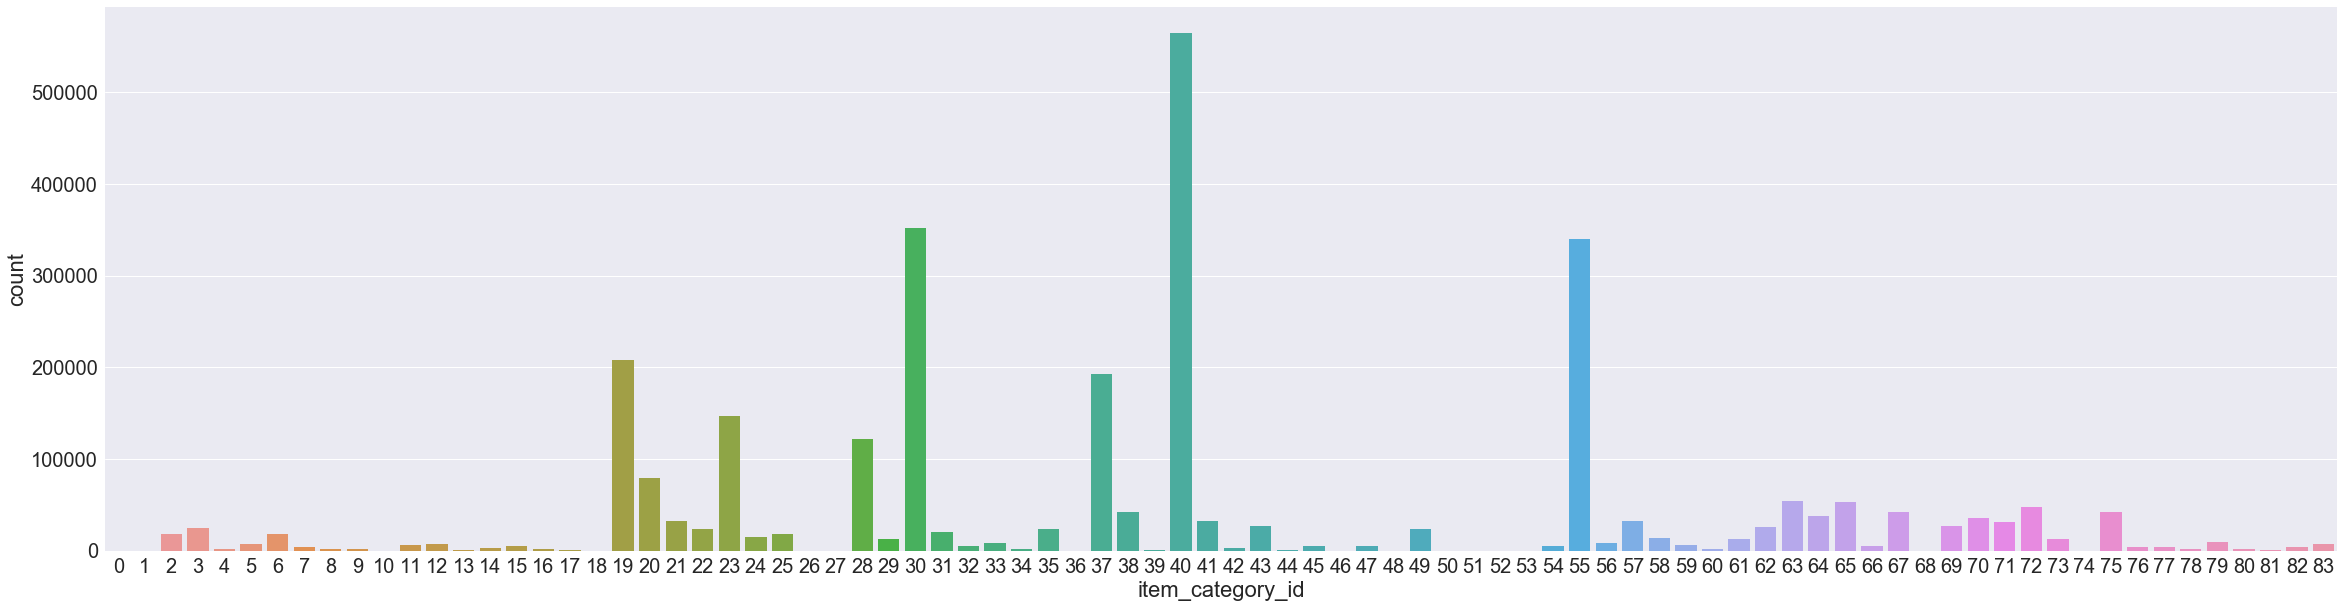

In [23]:
# which category of items had the best sales
plt.figure(figsize=(40,10))
sns.set(font_scale=2)
sns.countplot(x='item_category_id', data=train_df)


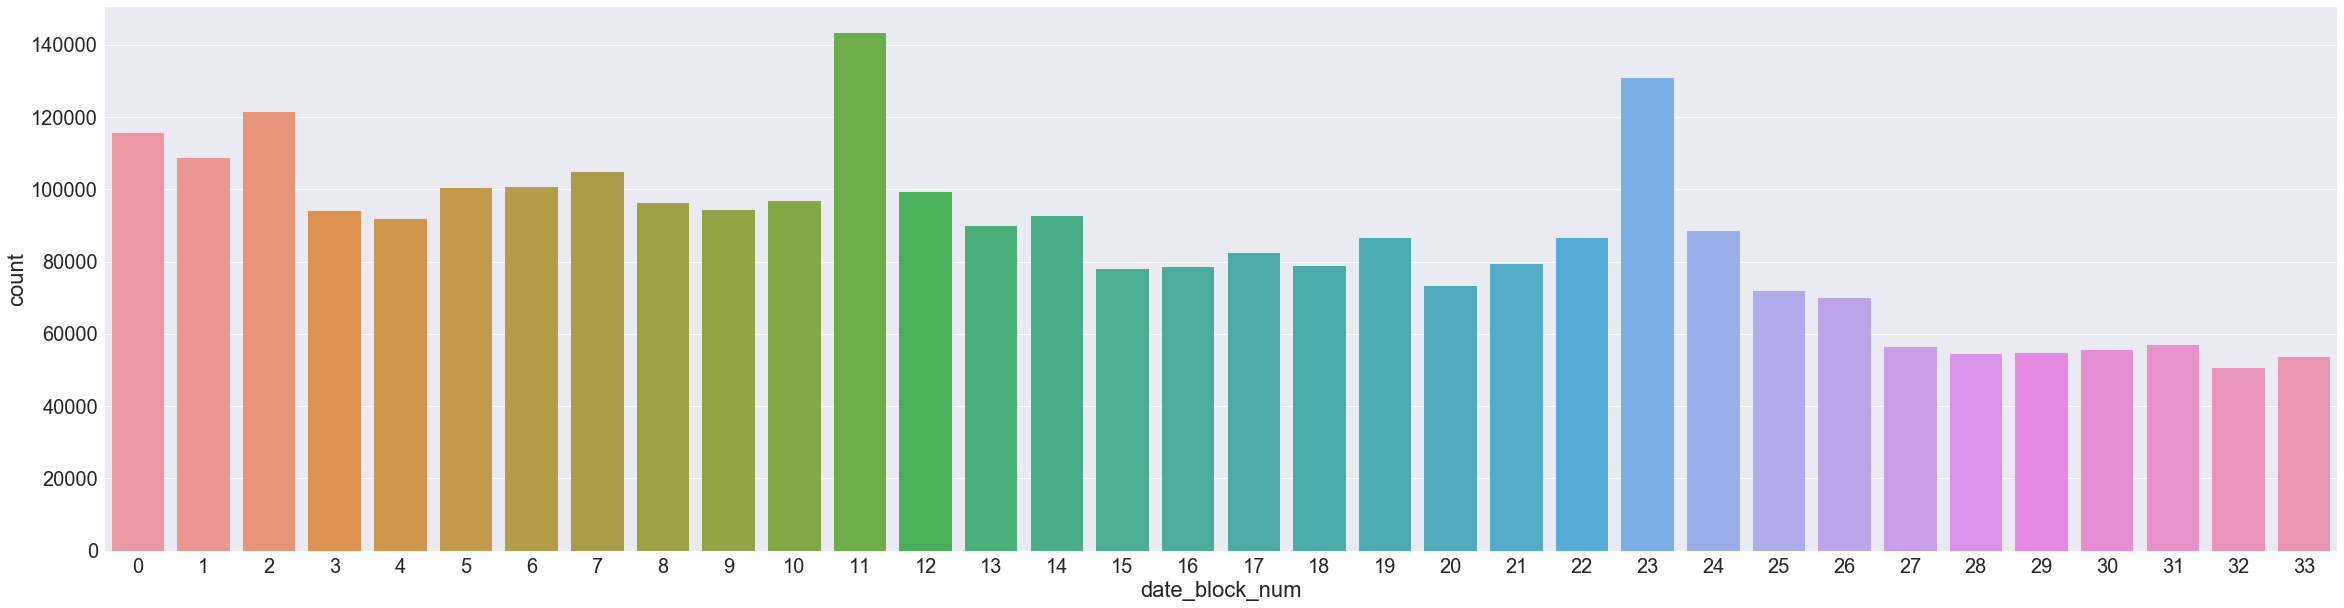

In [24]:
# find out which month had the highest items
plt.figure(figsize=(40,10))
sns.set(font_scale=2)
sns.countplot(x='date_block_num', data=train_df)


In [25]:
# get the day, month, day of the week
train_df["date"] = pd.to_datetime(train_df["date"], infer_datetime_format=True)
train_df["month"] = train_df["date"].dt.month
train_df["day"] = train_df["date"].dt.day
train_df["day_of_week"] = train_df["date"].dt.dayofweek

# test data
test_df["month"] = test_df["date"].dt.month
test_df["day"] = test_df["date"].dt.day
test_df["day_of_week"] = test_df["date"].dt.dayofweek

# make validation to be the last month(33)
# use a learning rate of 0.3

In [26]:
train_df["xmas"] = (train_df["month"] == 12).astype(int)
test_df["xmas"] = 0

##### Predicting the model

In [27]:
# training the models
train_data = train_df.drop(['date', 'item_price'], axis=1)
train_data.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,category,sub_category,city,item_count_per_month,month,day,day_of_week,xmas
0,0,59,22154,1.0,37,11,53,30,1.0,2,1,4,0
1,0,25,2552,1.0,58,12,64,10,0.0,3,1,4,0
2,0,25,2552,-1.0,58,12,64,10,0.0,5,1,2,0
3,0,25,2554,1.0,58,12,64,10,1.0,6,1,5,0
4,0,25,2555,1.0,56,12,12,10,1.0,1,15,1,0


In [28]:
y = train_data["item_count_per_month"].values # features
X = train_data.drop(["item_count_per_month"], axis=1).values # labels

In [29]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [30]:
# split train_data into training and validation
train_data, validation_data = train_test_split(train_data,  train_size=0.75, random_state=0)
print(train_data.shape)
print(validation_data.shape)

(2201886, 13)
(733963, 13)


In [31]:
# convert the dataset into LGBM format in this fromat:
# lgb.Dataset(data, label=label, feature_name=['c1', 'c2', 'c3'], categorical_feature=['c3'])
y = 'item_count_per_month'
x = ['date_block_num','shop_id','item_id','item_category_id', 'category', 'sub_category', 'city', 'month', 'day', 'day_of_week', 'xmas']
categorical = ['date_block_num', 'shop_id','item_id', 'item_category_id']

l_train = lgb.Dataset(train_data[x].values, 
                    label=train_data[y].values, 
                    feature_name=x,
                    categorical_feature=categorical
                        )

l_validation = lgb.Dataset(validation_data[x].values, 
                    label=validation_data[y].values, 
                    feature_name=x,
                    categorical_feature=categorical
                        )

In [32]:
# use grid search to get light gbm parameters
# lgb_estimator = lgb.LGBMClassifier()

# param_grid = {
#     'learning_rate': [0.005],
#     'n_estimators': [40],
#     'num_leaves': [6,8,12,16],
#     'boosting_type' : ['gbdt', 'rf'],
#     'objective' : ['binary'],
#     'random_state' : [501], # Updated from 'seed'
#     'colsample_bytree' : [0.65, 0.66],
#     'subsample' : [0.7,0.75],
#     'reg_alpha' : [1,1.2],
#     'reg_lambda' : [1,1.2,1.4],
#     }

# gs = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, scoring='accuracy')

# gs = gs.fit(train_data[x].values, train_data[y].values)

# print(gs.best_score_)
# print(gs.best_params_)


In [33]:
parameters = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric':'auc',
    'learning_rate': 0.5,
    'num_leaves': 150,
    'max_depth':2,  
    'min_data_in_leaf': 500,
    'min_sum_hessian_in_leaf': 50,
    'min_child_samples': 100,
    'max_bin': 75,  
    'subsample': 0.9,  
    'subsample_freq': 3,
    'colsample_bytree': 0.9,  
    'min_child_weight': 0,  
    'min_split_gain': 1,
    'min_gain_to_split': 1,
    'reg_alpha': 0, 
    'reg_lambda': 0,
}

In [34]:
# train the model
model = lgb.train(parameters,
                  l_train,
                  valid_sets=[l_train, l_validation],
                  valid_names=['train','valid'],
                  early_stopping_rounds=100,
                  num_boost_round=1000,
                  verbose_eval=50,)

/Users/rose/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/rose/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.833308	valid's auc: 0.797861
[100]	train's auc: 0.853582	valid's auc: 0.806383
[150]	train's auc: 0.870741	valid's auc: 0.814167
[200]	train's auc: 0.880976	valid's auc: 0.819328
[250]	train's auc: 0.890183	valid's auc: 0.823871
[300]	train's auc: 0.896785	valid's auc: 0.829044
[350]	train's auc: 0.900732	valid's auc: 0.829896
[400]	train's auc: 0.903791	valid's auc: 0.831044
[450]	train's auc: 0.906517	valid's auc: 0.830978
[500]	train's auc: 0.909449	valid's auc: 0.83364
[550]	train's auc: 0.911332	valid's auc: 0.833231
[600]	train's auc: 0.912756	valid's auc: 0.832446
Early stopping, best iteration is:
[502]	train's auc: 0.909497	valid's auc: 0.833739


In [35]:
y_predicted = model.predict(validation_data[x])
# calculate Root Mean Squared 
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(validation_data[y], y_predicted))
print("This is the RMSE", rms)

This is the RMSE 32.112263059157236


In [36]:
# predict on test data

test_pred = pd.DataFrame()
test_pred['ID'] = test_df['ID'].astype('int')

test_pred['item_cnt_month'] = model.predict(test_df[x])
test_pred.to_csv('submission.csv', index=False)

In [ ]:
The RSME on Kaggle Leaderboard is 1.4

In [ ]:
# random forest classifiers
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=2)

# param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 6, 8, 10, 12, 16], "n_estimators": [50, 200, 400, 700, 1000]}

# gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy')

# gs = gs.fit(X_train, y_train)

# print(gs.best_score_)
# print(gs.best_params_)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
print("fitting the data")
classifier.fit(X_train, y_train)
print ('Accuracy of Random forest classifier on training set: {:.2f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of Random forest classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

In [ ]:
test_pred['ID'] = test_df['ID'].astype('int')

test_pred['item_cnt_month'] = classifier.predict(np.array(test_df[x]))
test_pred.to_csv('submission_rf.csv', index=False)